KaggleDataset Link:

https://www.kaggle.com/datasets/nathanlauga/nba-games


In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


In [10]:
# Load the datasets
try:
    games_df = pd.read_csv('games.csv')
    games_details_df = pd.read_csv('games_details.csv', low_memory=False)
    players_df = pd.read_csv('players.csv')
    ranking_df = pd.read_csv('ranking.csv')
    teams_df = pd.read_csv('teams.csv')
    print("All datasets loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")


All datasets loaded successfully!


In [11]:
# Function to inspect a DataFrame
def inspect_df(df, name, describe=True):
    print(f"\n--- {name} DataFrame ---")
    print("Shape:", df.shape)
    df.info()
    print("\nFirst 5 rows:")
    print(df.head())
    if describe:
        print("\nBasic Statistics:")
        print(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum())

inspect_df(games_df, "Games")
inspect_df(games_details_df, "Game Details", describe=False)
inspect_df(players_df, "Players", describe=False)
inspect_df(ranking_df, "Ranking")
inspect_df(teams_df, "Teams")



--- Games DataFrame ---
Shape: (26651, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26651 entries, 0 to 26650
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GAME_DATE_EST     26651 non-null  object 
 1   GAME_ID           26651 non-null  int64  
 2   GAME_STATUS_TEXT  26651 non-null  object 
 3   HOME_TEAM_ID      26651 non-null  int64  
 4   VISITOR_TEAM_ID   26651 non-null  int64  
 5   SEASON            26651 non-null  int64  
 6   TEAM_ID_home      26651 non-null  int64  
 7   PTS_home          26552 non-null  float64
 8   FG_PCT_home       26552 non-null  float64
 9   FT_PCT_home       26552 non-null  float64
 10  FG3_PCT_home      26552 non-null  float64
 11  AST_home          26552 non-null  float64
 12  REB_home          26552 non-null  float64
 13  TEAM_ID_away      26651 non-null  int64  
 14  PTS_away          26552 non-null  float64
 15  FG_PCT_away       26552 non-null  float64
 

Data Frame Inspections Discussion:

This code just is meant to inspect all the dataframes i previously made just so i have a better general idea of the data I am working with. It just helps me to do this so I can better visualize how to do the rest of the analysis. It was also a very helpful tool for me to go back to when coding charts, plots, and histograms as it containst all the column names I need to accout for.

In [12]:
stat_cols = ['FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
             'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB',
             'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS']
existing_stat_cols = [col for col in stat_cols if col in games_details_df.columns]
games_details_df[existing_stat_cols] = games_details_df[existing_stat_cols].fillna(0)

if 'COMMENT' in games_details_df.columns:
    games_details_df.drop(columns=['COMMENT'], inplace=True)
    print("Dropped 'COMMENT' column.")

print("\nMissing Values after cleaning:")
print(games_details_df.isnull().sum())

print("\n--- Duplicate Checks ---")
for name, df in [('games', games_df), ('details', games_details_df),
                 ('players', players_df), ('ranking', ranking_df),
                 ('teams', teams_df)]:
    duplicates = df.duplicated().sum()
    print(f"{name}_df: {duplicates} duplicate rows")


Dropped 'COMMENT' column.

Missing Values after cleaning:
GAME_ID                   0
TEAM_ID                   0
TEAM_ABBREVIATION         0
TEAM_CITY                 0
PLAYER_ID                 0
PLAYER_NAME               0
NICKNAME             615591
START_POSITION       412863
MIN                  109690
FGM                       0
FGA                       0
FG_PCT                    0
FG3M                      0
FG3A                      0
FG3_PCT                   0
FTM                       0
FTA                       0
FT_PCT                    0
OREB                      0
DREB                      0
REB                       0
AST                       0
STL                       0
BLK                       0
TO                        0
PF                        0
PTS                       0
PLUS_MINUS                0
dtype: int64

--- Duplicate Checks ---
games_df: 0 duplicate rows
details_df: 21 duplicate rows
players_df: 0 duplicate rows
ranking_df: 0 duplicate rows
team

Missing Values Code Discussion:

This code is me trying to clean the data a bit across the files along with checking for missing values. After cleaning it, there were no missing values in the FGM, FGA, PTS, etc columns as i filled them with zeros since it often time correlating to said player not getting any PTS, FGM, or FGA. Next wwas handling the duplicate row, which I only found 21 of and does seem a bit low, but there are just too many rows for me to manually check.

In [13]:
if 'GAME_DATE_EST' in games_df.columns:
    games_df['GAME_DATE_EST'] = pd.to_datetime(games_df['GAME_DATE_EST'])

if 'STANDINGSDATE' in ranking_df.columns:
    ranking_df['STANDINGSDATE'] = pd.to_datetime(ranking_df['STANDINGSDATE'])

game_player_stats = pd.merge(games_details_df, players_df, on='PLAYER_ID', how='left')
game_player_stats = pd.merge(game_player_stats, games_df[['GAME_ID', 'GAME_DATE_EST', 'SEASON']], on='GAME_ID', how='left')

games_with_teams = pd.merge(games_df, teams_df, left_on='HOME_TEAM_ID', right_on='TEAM_ID', how='left')
games_with_teams.rename(columns={
    'NICKNAME': 'HOME_TEAM_NICKNAME',
    'CITY': 'HOME_TEAM_CITY',
    'ARENA': 'HOME_TEAM_ARENA',
    'YEARFOUNDED': 'HOME_TEAM_YEARFOUNDED'}, inplace=True)
games_with_teams.drop(columns=['TEAM_ID'], inplace=True)

games_with_teams = pd.merge(games_with_teams, teams_df, left_on='VISITOR_TEAM_ID', right_on='TEAM_ID', how='left')
games_with_teams.rename(columns={
    'NICKNAME': 'VISITOR_TEAM_NICKNAME',
    'CITY': 'VISITOR_TEAM_CITY',
    'ARENA': 'VISITOR_TEAM_ARENA',
    'YEARFOUNDED': 'VISITOR_TEAM_YEARFOUNDED'}, inplace=True)
games_with_teams.drop(columns=['TEAM_ID'], inplace=True)


Conversion Code Discussion:

The point of this code is a way for me to better prepare for player data anaylsis. I just wanted to convert all the data columns into a more standard format that would better allow me to merge multiple  data sets and create one comprehensive dataset. It also is me renaming columns for better clarity as some csv files had similar column names that were confusing.

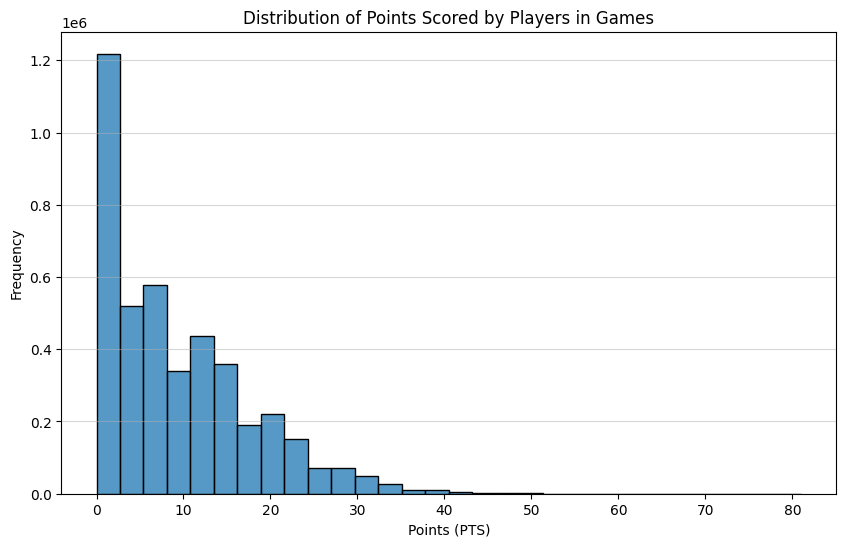

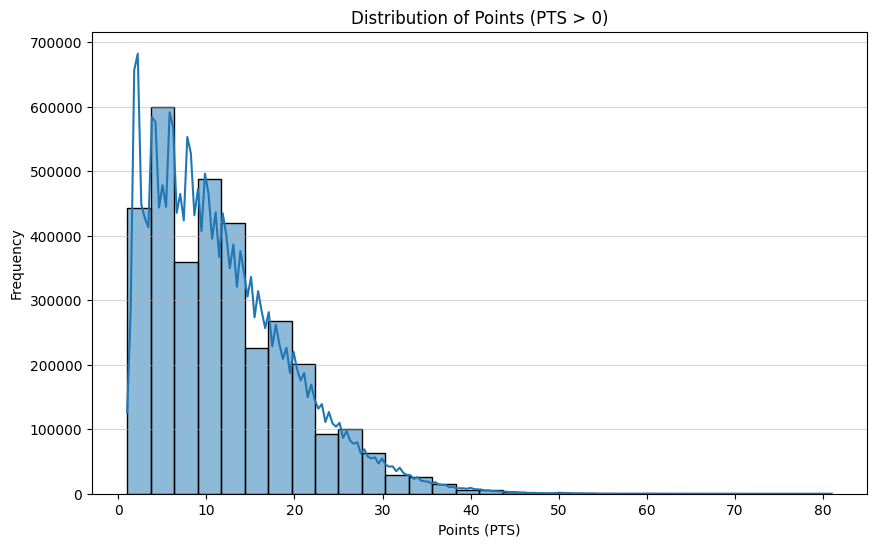

In [14]:
# Distribution of points per game
plt.figure(figsize=(10, 6))
sns.histplot(game_player_stats['PTS'], bins=30)
plt.title('Distribution of Points Scored by Players in Games')
plt.xlabel('Points (PTS)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()

# Distribution where PTS > 0
plt.figure(figsize=(10, 6))
sns.histplot(game_player_stats[game_player_stats['PTS'] > 0]['PTS'], bins=30, kde=True)
plt.title('Distribution of Points (PTS > 0)')
plt.xlabel('Points (PTS)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()


Results Discussion for Scoring Distribution:

When looking at scoring distribution, there is one main thing we are looking at, the overall spread of points, which shows us the frequency of high-scoring vs low-scoring games. It also can show us potential outliers. In plot above we can see the histogram skews to the right which makes sense because a majority of NBA players will be on the lower end of scoring. This is because most of a teams scoring will com from a select few players. We see four pretty noticably spikes which I think is a very good representation of the NBA's scoring structer. The first, and largest spike is in the 0-5 point range. This is made up of end of the bench players who don't play much, or players who dont play at all. Next is in the 10-15 point range. This is going to represent the average to above average NBA player. It will include your starters and best bench players. The third spike comse in the 20-25 range. This will often times be the second best player on good teams, or the best player on bad teams. The final spike is at the 25-35 point range. This spike represents the NBA's superstars. There might on be one player, if that on a single team and that player is going to contribute most to a teams scoring.


Top 10 Players by Efficiency in the 2020 Season:
     PLAYER_ID          PLAYER_NAME_x        EFF
177     203999           Nikola Jokic  35.366667
139     203507  Giannis Antetokounmpo  31.402174
169     203954            Joel Embiid  28.571429
223    1627734       Domantas Sabonis  28.194444
375    1629029            Luka Doncic  28.089744
191    1626157     Karl-Anthony Towns  27.927273
80      202696         Nikola Vucevic  27.480000
27      201566      Russell Westbrook  27.423077
42      201935           James Harden  27.412698
18      201142           Kevin Durant  27.174603


<ipython-input-39-95d3730dc1ea>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=efficiency_leaders, x='EFF', y='PLAYER_NAME_x', palette='viridis')


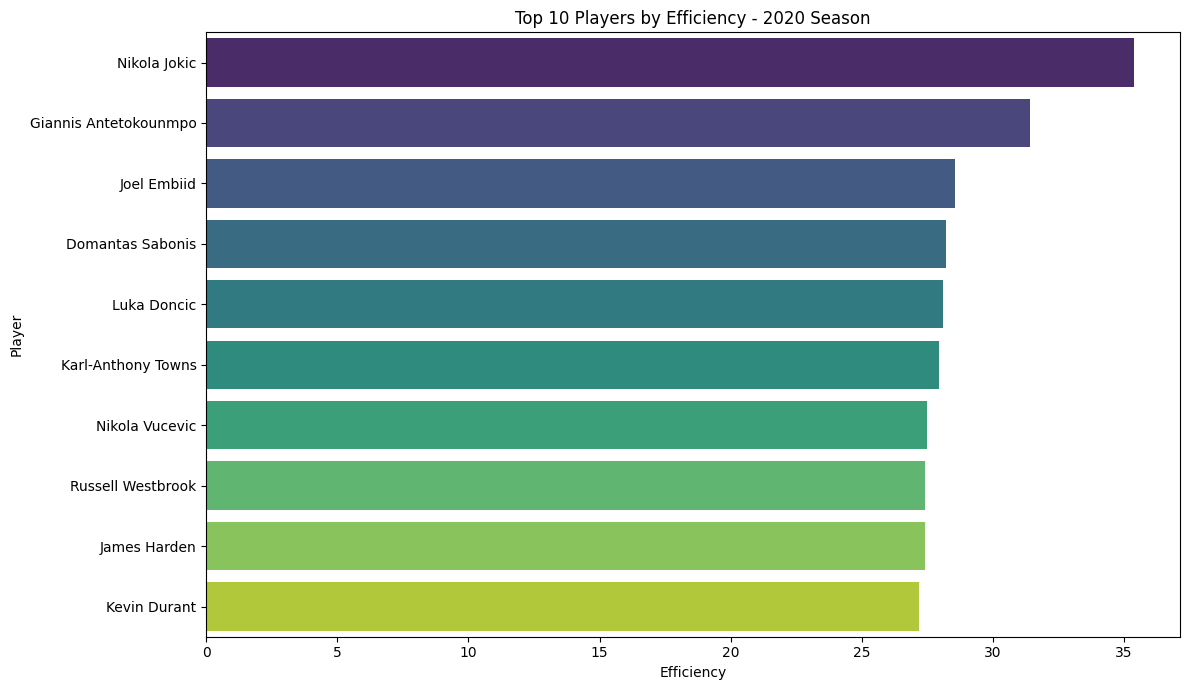

In [39]:
# Top 10 Player Efficiency Ratings 2020
game_player_stats['EFF'] = (
    game_player_stats['PTS'] + game_player_stats['OREB'] + game_player_stats['DREB'] +
    game_player_stats['AST'] + game_player_stats['STL'] + game_player_stats['BLK'] -
    (game_player_stats['FGA'] - game_player_stats['FGM']) -
    (game_player_stats['FTA'] - game_player_stats['FTM']) -
    game_player_stats['TO']
)

target_season = 2020
season_stats = game_player_stats[game_player_stats['SEASON_y'] == target_season]

efficiency_leaders = season_stats.groupby(['PLAYER_ID', 'PLAYER_NAME_x'])['EFF'].mean().reset_index()
efficiency_leaders = efficiency_leaders.sort_values(by='EFF', ascending=False).head(10)

print(f"\nTop 10 Players by Efficiency in the {target_season} Season:")
print(efficiency_leaders)

plt.figure(figsize=(12, 7))
sns.barplot(data=efficiency_leaders, x='EFF', y='PLAYER_NAME_x', palette='viridis')
plt.title(f'Top 10 Players by Efficiency - {target_season} Season')
plt.xlabel('Efficiency')
plt.ylabel('Player')
plt.tight_layout()
plt.show()


Results Discussion for Player Efficiency Rating:

In basketball, Player Efficiency Rating (PER) is a way breakdown a players overall efficiency into one number that takes into account points scored, rebounds, assists, steals, blocks, and other key offensive and defensive metrics.The higher the PER, tthe better, and more impactful the player. We can see this correlation in the top 10 players list. In first we have Nikola Jokic who currently is widely considered as the best basketball player in the world. He is followed by other notable names such as Luka Doncic, and Kevin Durant


Overall Home Team Win Percentage: 58.70%

Home Win % by Season:
SEASON
2003    57.761733
2004    60.499266
2005    60.474860
2006    59.126145
2007    61.091425
2008    60.140351
2009    60.182584
2010    61.251758
2011    59.420290
2012    61.408451
2013    57.393132
2014    57.545839
2015    59.392655
2016    58.078292
2017    58.248915
2018    58.780842
2019    53.666398
2020    54.523619
2021    55.291577
2022    58.856089
Name: HOME_TEAM_WINS, dtype: float64


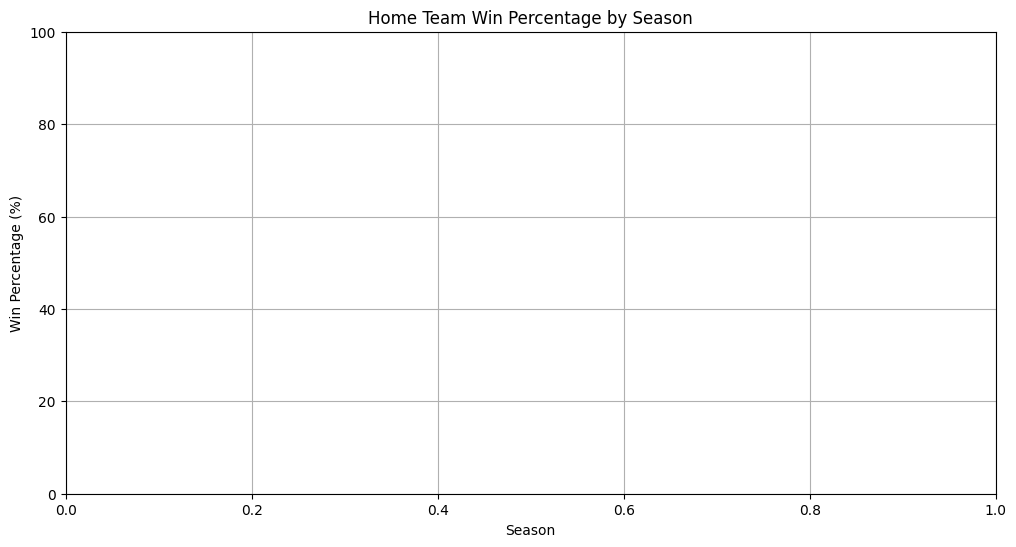

In [40]:
# Home Court Advantage
if 'HOME_TEAM_WINS' in games_with_teams.columns:
    home_win_pct = games_with_teams['HOME_TEAM_WINS'].mean() * 100
    print(f"\nOverall Home Team Win Percentage: {home_win_pct:.2f}%")

    if 'SEASON' in games_with_teams.columns:
        win_by_season = games_with_teams.groupby('SEASON')['HOME_TEAM_WINS'].mean() * 100
        print("\nHome Win % by Season:")
        print(win_by_season)

        plt.figure(figsize=(12, 6))
        win_by_season.plot(marker='o')
        plt.title('Home Team Win Percentage by Season')
        plt.xlabel('Season')
        plt.ylabel('Win Percentage (%)')
        plt.ylim(0, 100)
        plt.grid(True)
        plt.show()


Home Team Win % Discussion:

This code lets me analyze home court advantage in the NBA and see if it is really a thing, or just a sports superstition. I found the average to be %58.70 which was more significant then I thought. I think what sticks out most to me is the dive the percentage wakes in 2019/2020, when the league was shut down due to Covid. After this it has steadily rose, but still took time. I think this is just because fans in general, whether home or away were less likely to attend games which made their impact less noticable for the players.

In [42]:
output_file = 'merged_game_player_stats.csv'
game_player_stats.to_csv(output_file, index=False)
print(f"Merged data exported to '{output_file}' successfully as CSV.")


Merged data exported to 'merged_game_player_stats.csv' successfully as CSV.


File Output Discussion:

This is just simple code to export the file to a csv file. It is too big for an Excel file.